In [14]:
# !pip install transformer dataset evaluate
"""Fine tuning sshleifer/distilbart-cnn-12-6 for legal summarize"""
# Install dependencies (run once)
!pip install -q transformers datasets evaluate accelerate rouge_score
!pip install -q nltk  # for additional text processing

# ------------------------------
# 1) Imports and hyperparameters
# ------------------------------
import os
import math
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback,
    set_seed
)
import evaluate
import nltk
nltk.download('punkt', quiet=True)

True

In [15]:
set_seed(42)

BATCH_SIZE = 4
NUM_TRAIN_EPOCHS = 3
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01
MAX_SOURCE_LENGTH = 1024
MAX_TARGET_LENGTH = 128
TRAINING_DATASET_SIZE = 500
TESTING_DATASET_SIZE = 50


# Local directories
GDRIVE_OUTPUT_DIR = "/content/cache"
GDRIVE_FINAL_MODEL_DIR = "/content/model"

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Drive directories
GDRIVE_BASE_DIR = "/content/drive/MyDrive/LegalSummarizer"
GDRIVE_OUTPUT_DIR = os.path.join(GDRIVE_BASE_DIR, "cache")
GDRIVE_FINAL_MODEL_DIR = os.path.join(GDRIVE_BASE_DIR, "model")

# CSVs saved to Drive
ROUGE_CSV_PATH = os.path.join(GDRIVE_BASE_DIR, "rouge_scores.csv")
TRAIN_SUMMARY_CSV = os.path.join(GDRIVE_BASE_DIR, "train_summaries.csv")
TEST_SUMMARY_CSV = os.path.join(GDRIVE_BASE_DIR, "test_summaries.csv")
METRICS_HISTORY_CSV = os.path.join(GDRIVE_BASE_DIR, "training_metrics.csv")


CHECKPOINT = "sshleifer/distilbart-cnn-12-6"  # Speed vs performance
PREFIX = "summarize legal case: "

for dir_path in [GDRIVE_OUTPUT_DIR, GDRIVE_FINAL_MODEL_DIR, GDRIVE_OUTPUT_DIR, GDRIVE_FINAL_MODEL_DIR]:
    os.makedirs(dir_path, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [16]:
# ------------------------------
# 2) Enhanced dataset loading & preprocessing
# ------------------------------
def load_and_prepare_data():
    """Load and prepare legal dataset with enhanced preprocessing"""
    print("Loading dataset from Hugging Face...")
    try:
        raw = load_dataset("d0r1h/ILC")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        raise

    # Convert and sample data
    train_df = raw["train"].to_pandas().head(TRAINING_DATASET_SIZE).reset_index(drop=True)
    test_df = raw["test"].to_pandas().head(TESTING_DATASET_SIZE).reset_index(drop=True)

    print("Dataset info:")
    print(f"Columns: {train_df.columns.tolist()}")
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")

    # Verify required columns
    required_cols = ["Case", "Summary"]
    missing_cols = [col for col in required_cols if col not in train_df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Data quality checks and cleaning
    def clean_text(text):
        """Basic text cleaning for legal documents"""
        if pd.isna(text):
            return ""
        text = str(text).strip()
        # Remove excessive whitespace
        text = " ".join(text.split())
        return text

    train_df["Case"] = train_df["Case"].apply(clean_text)
    train_df["Summary"] = train_df["Summary"].apply(clean_text)
    test_df["Case"] = test_df["Case"].apply(clean_text)
    test_df["Summary"] = test_df["Summary"].apply(clean_text)

    # Remove samples with empty text
    train_df = train_df[(train_df["Case"].str.len() > 50) & (train_df["Summary"].str.len() > 10)]
    test_df = test_df[(test_df["Case"].str.len() > 50) & (test_df["Summary"].str.len() > 10)]

    print(f"After cleaning - Train: {len(train_df)}, Test: {len(test_df)}")

    # Calculate text statistics
    train_case_lens = train_df["Case"].str.split().str.len()
    train_summary_lens = train_df["Summary"].str.split().str.len()

    print("\nText length statistics:")
    print(f"Case length - Mean: {train_case_lens.mean():.0f}, Max: {train_case_lens.max()}")
    print(f"Summary length - Mean: {train_summary_lens.mean():.0f}, Max: {train_summary_lens.max()}")

    # Convert to HuggingFace datasets
    hf_train = Dataset.from_pandas(train_df)
    hf_test = Dataset.from_pandas(test_df)
    legal_data = DatasetDict({"train": hf_train, "test": hf_test})

    # Save processed data
    train_df.to_csv("./train_dataset_processed.csv", index=False)
    test_df.to_csv("./test_dataset_processed.csv", index=False)
    print("Saved processed datasets")

    return legal_data, train_df, test_df

legal_data, train_df, test_df = load_and_prepare_data()


Loading dataset from Hugging Face...
Dataset info:
Columns: ['Title', 'Summary', 'Case']
Train samples: 500
Test samples: 50
After cleaning - Train: 500, Test: 50

Text length statistics:
Case length - Mean: 2382, Max: 7817
Summary length - Mean: 550, Max: 4267
Saved processed datasets


In [17]:
# ------------------------------
# 3) Enhanced tokenizer & model setup
# ------------------------------
print("Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, use_fast=True)

# Handle models without pad_token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSeq2SeqLM.from_pretrained(CHECKPOINT)

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {total_params:,} total, {trainable_params:,} trainable")

model = model.to(device)

Loading tokenizer and model...
Model parameters: 305,510,400 total, 305,510,400 trainable


In [18]:
# ------------------------------
# 4) Enhanced preprocessing
# ------------------------------
def preprocess_function(examples):
    """Enhanced preprocessing with better handling"""
    # Add legal-specific prefix
    inputs = [PREFIX + str(case) for case in examples["Case"]]

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_SOURCE_LENGTH,
        truncation=True,
        padding="max_length",
        return_tensors=None
    )

    # Tokenize targets
    labels = tokenizer(
        text_target=examples["Summary"],
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding="max_length",
        return_tensors=None
    )

    # Replace padding tokens in labels with -100 for loss calculation
    label_ids = []
    for label_seq in labels["input_ids"]:
        label_seq = [
            (token if token != tokenizer.pad_token_id else -100)
            for token in label_seq
        ]
        label_ids.append(label_seq)

    model_inputs["labels"] = label_ids
    return model_inputs

print("Tokenizing dataset...")
tokenized_legal = legal_data.map(
    preprocess_function,
    batched=True,
    remove_columns=legal_data["train"].column_names,
    desc="Tokenizing"
)

print(f"Tokenized dataset sizes:")
print(f"Train: {len(tokenized_legal['train'])}")
print(f"Test: {len(tokenized_legal['test'])}")


Tokenizing dataset...


Tokenizing:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenized dataset sizes:
Train: 500
Test: 50


In [19]:
# ------------------------------
# 5) Enhanced metrics and data collator
# ------------------------------
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    pad_to_multiple_of=8  # Better for tensor cores
)

# Load metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

def compute_metrics(eval_pred):
    """Enhanced metrics computation"""
    predictions, labels = eval_pred

    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 with pad_token_id in labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Clean up decoded text
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Compute ROUGE scores
    rouge_result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # Compute BLEU score (additional metric)
    try:
        bleu_result = bleu.compute(
            predictions=decoded_preds,
            references=[[label] for label in decoded_labels]
        )
        bleu_score = bleu_result["bleu"]
    except:
        bleu_score = 0.0

    # Calculate generation length statistics
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id)
        for pred in predictions
    ]

    result = {
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "bleu": bleu_score,
        "gen_len": np.mean(prediction_lens),
        "gen_len_std": np.std(prediction_lens)
    }

    return {k: round(v, 4) for k, v in result.items()}


In [20]:
# ------------------------------
# 6) Enhanced training arguments
# ------------------------------
# Determine precision settings
if torch.cuda.is_available():
    if torch.cuda.get_device_capability()[0] >= 8:  # Ampere or newer
        fp16_flag, bf16_flag = False, True
    else:
        fp16_flag, bf16_flag = True, False
else:
    fp16_flag, bf16_flag = False, False

training_args = Seq2SeqTrainingArguments(
    output_dir=GDRIVE_OUTPUT_DIR,

    # Evaluation strategy
    eval_strategy="steps",
    eval_steps=100,

    # Learning parameters
    learning_rate=LEARNING_RATE,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,

    # Batch sizes and memory optimization
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=2,
    dataloader_pin_memory=True,
    dataloader_num_workers=2,

    # Regularization
    weight_decay=WEIGHT_DECAY,

    # Training duration
    num_train_epochs=NUM_TRAIN_EPOCHS,

    # Saving and checkpointing
    save_strategy="steps",
    save_steps=200,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeL",
    greater_is_better=True,

    # Generation settings
    predict_with_generate=True,
    generation_max_length=MAX_TARGET_LENGTH,
    generation_num_beams=4,

    # Precision
    fp16=fp16_flag,
    bf16=bf16_flag,

    # Logging
    logging_strategy="steps",
    logging_steps=50,
    report_to=[],  # Explicitly disable all reporting integrations

    # Memory optimization
    gradient_checkpointing=True,
    remove_unused_columns=False,

    # Reproducibility
    seed=42,
    data_seed=42,

    # Hub
    push_to_hub=False
)

# Create trainer with callbacks
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_legal["train"],
    eval_dataset=tokenized_legal["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [21]:
# ------------------------------
# 7) Enhanced training with monitoring
# ------------------------------
!pip install wandb


def train_with_monitoring():
    """Train with enhanced monitoring and error handling"""
    print("Starting training...")
    print(f"Total steps: {len(tokenized_legal['train']) // (BATCH_SIZE * 2) * NUM_TRAIN_EPOCHS}")

    try:
        # Check for existing checkpoints
        checkpoints = [
            d for d in os.listdir(GDRIVE_OUTPUT_DIR)
            if d.startswith('checkpoint-') and os.path.isdir(os.path.join(GDRIVE_OUTPUT_DIR, d))
        ]

        if checkpoints:
            latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('-')[-1]))
            checkpoint_path = os.path.join(GDRIVE_OUTPUT_DIR, latest_checkpoint)
            print(f"Resuming from checkpoint: {checkpoint_path}")
            train_result = trainer.train(resume_from_checkpoint=checkpoint_path)
        else:
            train_result = trainer.train()

        print("Training completed successfully!")
        print(f"Training loss: {train_result.training_loss:.4f}")

        # Save training metrics
        metrics_df = pd.DataFrame(trainer.state.log_history)
        metrics_df.to_csv(METRICS_HISTORY_CSV, index=False)
        print(f"Training metrics saved to {METRICS_HISTORY_CSV}")

        return train_result

    except KeyboardInterrupt:
        print("Training interrupted by user")
        trainer.save_model(f"{GDRIVE_FINAL_MODEL_DIR}_interrupted")
        return None
    except Exception as e:
        print(f"Training failed: {e}")
        if hasattr(trainer, 'model'):
            trainer.save_model(f"{GDRIVE_FINAL_MODEL_DIR}_failed")
        raise

# Run training
train_result = train_with_monitoring()

# Save final model and tokenizer
trainer.save_model(GDRIVE_FINAL_MODEL_DIR)
tokenizer.save_pretrained(GDRIVE_FINAL_MODEL_DIR)
print(f"Final model and tokenizer saved to {GDRIVE_FINAL_MODEL_DIR}")


Starting training...
Total steps: 186


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Gen Len,Gen Len Std
100,2.093300,2.152584,0.422000,0.187300,0.256400,0.140700,126.220000,4.460000


Training completed successfully!
Training loss: 2.1248
Training metrics saved to /content/drive/MyDrive/LegalSummarizer/training_metrics.csv
Final model and tokenizer saved to /content/model


In [22]:
# ------------------------------
# 8) Enhanced evaluation
# ------------------------------
print("Performing comprehensive evaluation...")

# Evaluate on both sets
train_metrics = trainer.evaluate(eval_dataset=tokenized_legal["train"], metric_key_prefix="train")
test_metrics = trainer.evaluate(eval_dataset=tokenized_legal["test"], metric_key_prefix="test")

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"Train ROUGE-L: {train_metrics['train_rougeL']:.4f}")
print(f"Test ROUGE-L:  {test_metrics['test_rougeL']:.4f}")
print(f"Train BLEU:    {train_metrics['train_bleu']:.4f}")
print(f"Test BLEU:     {test_metrics['test_bleu']:.4f}")

# Prepare data for visualization
metrics_names = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU"]
train_scores = [
    train_metrics.get("train_rouge1", 0),
    train_metrics.get("train_rouge2", 0),
    train_metrics.get("train_rougeL", 0),
    train_metrics.get("train_bleu", 0)
]
test_scores = [
    test_metrics.get("test_rouge1", 0),
    test_metrics.get("test_rouge2", 0),
    test_metrics.get("test_rougeL", 0),
    test_metrics.get("test_bleu", 0)
]

# Save metrics to CSV
metrics_df = pd.DataFrame({
    "Metric": metrics_names,
    "Training": train_scores,
    "Testing": test_scores
})
metrics_df.to_csv(ROUGE_CSV_PATH, index=False)
print(f"\nMetrics saved to {ROUGE_CSV_PATH}")


Performing comprehensive evaluation...


early stopping required metric_for_best_model, but did not find eval_rougeL so early stopping is disabled
early stopping required metric_for_best_model, but did not find eval_rougeL so early stopping is disabled



EVALUATION RESULTS
Train ROUGE-L: 0.2931
Test ROUGE-L:  0.2564
Train BLEU:    0.1928
Test BLEU:     0.1444

Metrics saved to /content/drive/MyDrive/LegalSummarizer/rouge_scores.csv


In [23]:
# ------------------------------
# 9) Enhanced batch inference and summary generation
# ------------------------------
def generate_summaries_batch(dataset_tokenized, dataset_name="dataset"):
    """Generate summaries with enhanced error handling"""
    print(f"Generating summaries for {dataset_name}...")

    try:
        # Use trainer.predict for batched generation
        preds = trainer.predict(
            dataset_tokenized,
            max_length=MAX_TARGET_LENGTH,
            num_beams=4,
            length_penalty=0.8,
            no_repeat_ngram_size=2
        )

        pred_ids = preds.predictions
        if isinstance(pred_ids, tuple):
            pred_ids = pred_ids[0]

        # Decode summaries
        decoded_summaries = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
        decoded_summaries = [summary.strip() for summary in decoded_summaries]

        return decoded_summaries

    except Exception as e:
        print(f"Error generating summaries: {e}")
        return ["Error generating summary"] * len(dataset_tokenized)

# Generate summaries
train_summaries = generate_summaries_batch(tokenized_legal["train"], "training set")
test_summaries = generate_summaries_batch(tokenized_legal["test"], "test set")

# Create enhanced output DataFrames
def create_summary_df(original_df, generated_summaries, split_name):
    """Create enhanced summary DataFrame with additional analysis"""
    df = original_df.copy()
    df["Generated_Summary"] = generated_summaries[:len(df)]

    # Add text statistics
    df["Case_Word_Count"] = df["Case"].str.split().str.len()
    df["Reference_Word_Count"] = df["Summary"].str.split().str.len()
    df["Generated_Word_Count"] = df["Generated_Summary"].str.split().str.len()

    # Add compression ratio
    df["Compression_Ratio"] = df["Generated_Word_Count"] / df["Case_Word_Count"]

    return df

train_results_df = create_summary_df(train_df, train_summaries, "train")
test_results_df = create_summary_df(test_df, test_summaries, "test")

# Save results
train_results_df.to_csv(TRAIN_SUMMARY_CSV, index=False)
test_results_df.to_csv(TEST_SUMMARY_CSV, index=False)

print(f"\nSummary results saved:")
print(f"  Training: {TRAIN_SUMMARY_CSV}")
print(f"  Testing:  {TEST_SUMMARY_CSV}")

Generating summaries for training set...


Generating summaries for test set...



Summary results saved:
  Training: /content/drive/MyDrive/LegalSummarizer/train_summaries.csv
  Testing:  /content/drive/MyDrive/LegalSummarizer/test_summaries.csv


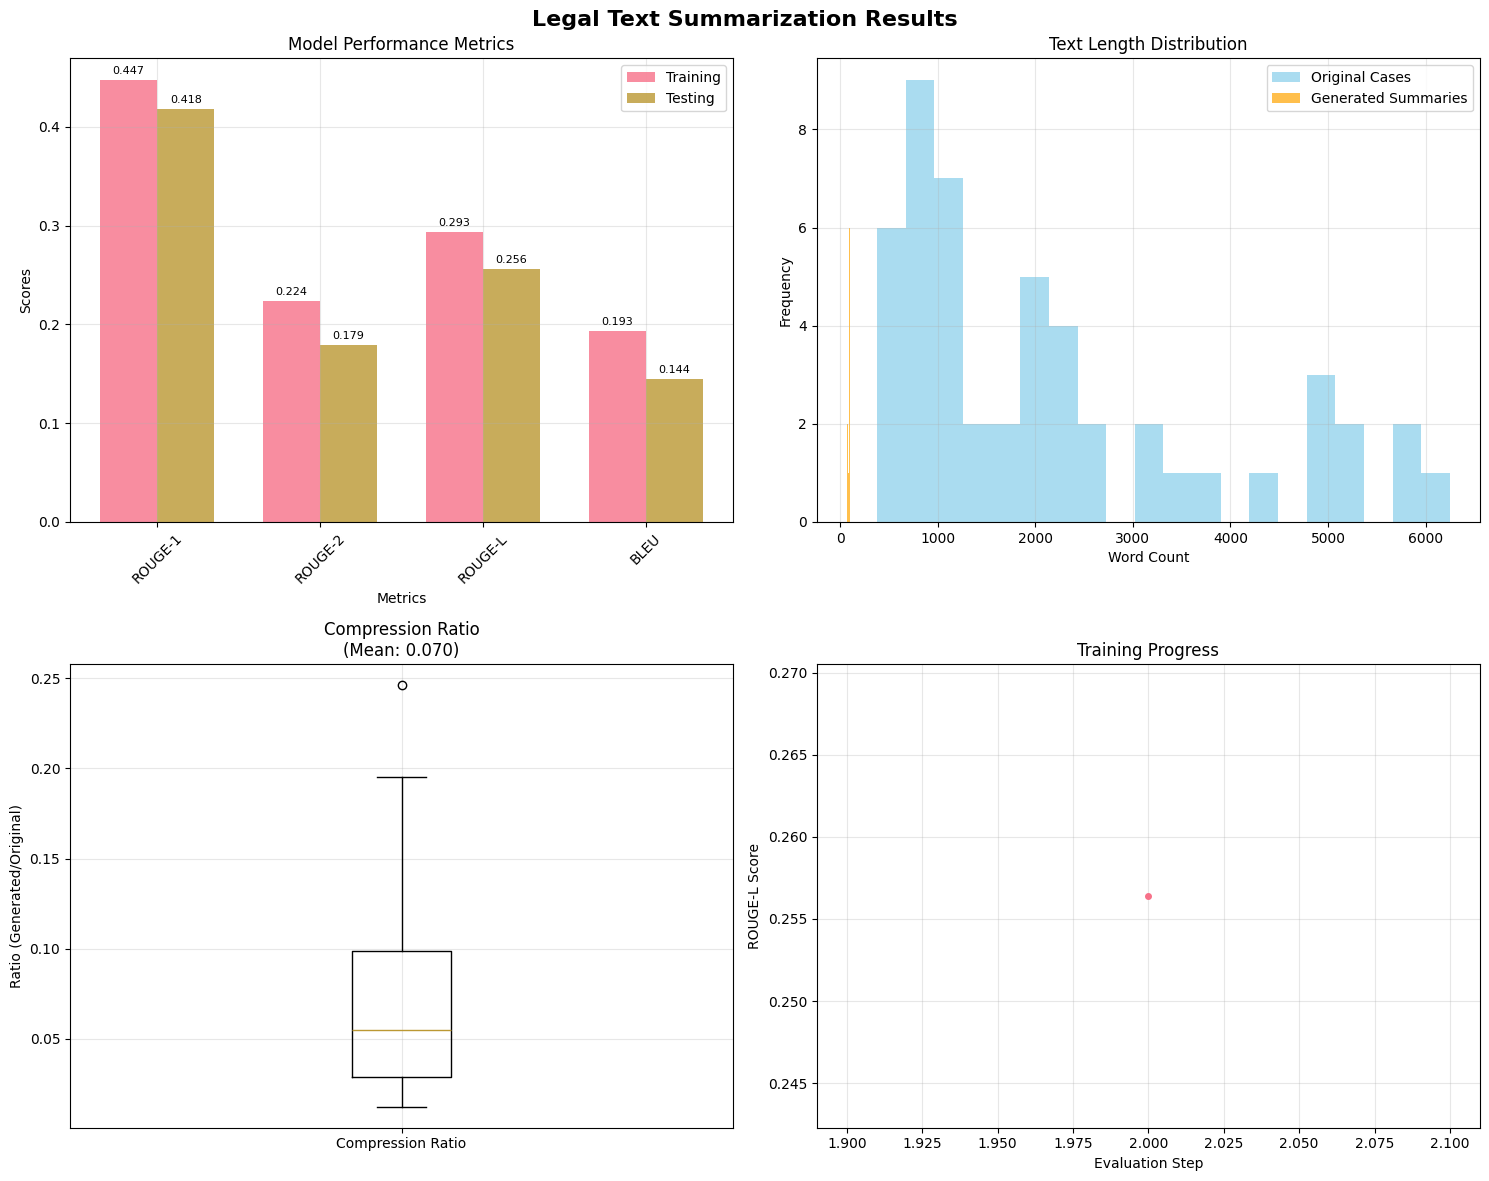

Comprehensive results plot saved to ./comprehensive_results.png


In [24]:
# ------------------------------
# 10) Enhanced visualization
# ------------------------------
def create_enhanced_plots():
    """Create comprehensive visualization plots"""

    # Set style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Legal Text Summarization Results', fontsize=16, fontweight='bold')

    # 1. ROUGE/BLEU Scores Comparison
    ax1 = axes[0, 0]
    x = np.arange(len(metrics_names))
    width = 0.35

    bars1 = ax1.bar(x - width/2, train_scores, width, label='Training', alpha=0.8)
    bars2 = ax1.bar(x + width/2, test_scores, width, label='Testing', alpha=0.8)

    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Scores')
    ax1.set_title('Model Performance Metrics')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_names, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    # 2. Text Length Distribution
    ax2 = axes[0, 1]
    ax2.hist(test_results_df["Case_Word_Count"], bins=20, alpha=0.7, label='Original Cases', color='skyblue')
    ax2.hist(test_results_df["Generated_Word_Count"], bins=20, alpha=0.7, label='Generated Summaries', color='orange')
    ax2.set_xlabel('Word Count')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Text Length Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Compression Ratio Analysis
    ax3 = axes[1, 0]
    compression_ratios = test_results_df["Compression_Ratio"]
    ax3.boxplot(compression_ratios, labels=['Compression Ratio'])
    ax3.set_ylabel('Ratio (Generated/Original)')
    ax3.set_title(f'Compression Ratio\n(Mean: {compression_ratios.mean():.3f})')
    ax3.grid(True, alpha=0.3)

    # 4. Training Progress (if available)
    ax4 = axes[1, 1]
    if os.path.exists(METRICS_HISTORY_CSV):
        history_df = pd.read_csv(METRICS_HISTORY_CSV)
        if 'eval_rougeL' in history_df.columns:
            steps = history_df.dropna(subset=['eval_rougeL'])
            ax4.plot(steps.index, steps['eval_rougeL'], marker='o', linewidth=2, markersize=4)
            ax4.set_xlabel('Evaluation Step')
            ax4.set_ylabel('ROUGE-L Score')
            ax4.set_title('Training Progress')
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'No training history\navailable',
                    ha='center', va='center', transform=ax4.transAxes)
    else:
        ax4.text(0.5, 0.5, 'No training history\navailable',
                ha='center', va='center', transform=ax4.transAxes)

    plt.tight_layout()
    plt.savefig('./comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Comprehensive results plot saved to ./comprehensive_results.png")

create_enhanced_plots()

In [25]:

# ------------------------------
# 11) Sample predictions showcase
# ------------------------------
def showcase_predictions(n_samples=3):
    """Display sample predictions for qualitative analysis"""
    print("\n" + "="*80)
    print("SAMPLE PREDICTIONS")
    print("="*80)

    for i in range(min(n_samples, len(test_results_df))):
        row = test_results_df.iloc[i]

        print(f"\n--- SAMPLE {i+1} ---")
        print(f"Original Case (first 200 chars):")
        print(f"  {row['Case'][:200]}...")
        print(f"\nReference Summary:")
        print(f"  {row['Summary']}")
        print(f"\nGenerated Summary:")
        print(f"  {row['Generated_Summary']}")
        print(f"\nStatistics:")
        print(f"  Original length: {row['Case_Word_Count']} words")
        print(f"  Reference length: {row['Reference_Word_Count']} words")
        print(f"  Generated length: {row['Generated_Word_Count']} words")
        print(f"  Compression ratio: {row['Compression_Ratio']:.3f}")
        print("-" * 80)

showcase_predictions()




SAMPLE PREDICTIONS

--- SAMPLE 1 ---
Original Case (first 200 chars):
  Reportable IN THE CIVIL APPELLATE JURISDICTION Civil Appeal No 10521 Arising out of SLP(C) No 57517) Chief General ManagerM P Power Trading Co Ltd & Anr Appellant(s) Narmada Equipments Pvt Ltd JUDGMEN...

Reference Summary:
  Section 86(1)(f) vests a statutory jurisdiction with the State Electricity Commission to adjudicate upon disputes between licensees and generating companies and to refer any dispute for arbitration. therefore, the appointment of arbitrators by the commission overrides the appointment of arbitrators by the High Court. This judgment was passed in the case of Chief General Manager (IPC) M P Power Trading Co. Ltd. &amp; Anr. vs. Narmada Equipments Pvt. Ltd. [C.A.No.1051/2021] by a Bench consisting of Hon’ble Justice Dr. Dhananjaya Y Chandrachud, Hon’ble Justice M R Shah, and Hon’ble Justice Sanjiv Khanna. The present appeal arose from a judgment passed by the MP High Court where it appointed an A

In [26]:
# ------------------------------
# Final Summary
# ------------------------------
print("\n" + "="*80)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"Model: {CHECKPOINT}")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Final Test ROUGE-L: {test_metrics.get('test_rougeL', 0):.4f}")
print(f"Final Test BLEU: {test_metrics.get('test_bleu', 0):.4f}")

print(f"\nGenerated Files:")
print(f"  📁 Model: {GDRIVE_FINAL_MODEL_DIR}/")
print(f"  📊 Metrics: {ROUGE_CSV_PATH}")
print(f"  📈 Plots: ./comprehensive_results.png")
print(f"  📄 Training summaries: {TRAIN_SUMMARY_CSV}")
print(f"  📄 Test summaries: {TEST_SUMMARY_CSV}")
if os.path.exists(METRICS_HISTORY_CSV):
    print(f"  📋 Training history: {METRICS_HISTORY_CSV}")

print(f"\nModel ready for inference! Load with:")
print(f"  tokenizer = AutoTokenizer.from_pretrained('{GDRIVE_FINAL_MODEL_DIR}')")
print(f"  model = AutoModelForSeq2SeqLM.from_pretrained('{GDRIVE_FINAL_MODEL_DIR}')")
print("="*80)


PIPELINE COMPLETED SUCCESSFULLY!
Model: sshleifer/distilbart-cnn-12-6
Training samples: 500
Test samples: 50
Final Test ROUGE-L: 0.2564
Final Test BLEU: 0.1444

Generated Files:
  📁 Model: /content/model/
  📊 Metrics: /content/drive/MyDrive/LegalSummarizer/rouge_scores.csv
  📈 Plots: ./comprehensive_results.png
  📄 Training summaries: /content/drive/MyDrive/LegalSummarizer/train_summaries.csv
  📄 Test summaries: /content/drive/MyDrive/LegalSummarizer/test_summaries.csv
  📋 Training history: /content/drive/MyDrive/LegalSummarizer/training_metrics.csv

Model ready for inference! Load with:
  tokenizer = AutoTokenizer.from_pretrained('/content/model')
  model = AutoModelForSeq2SeqLM.from_pretrained('/content/model')
